In [1]:
from traffic.core import Traffic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data, assign unique flight IDs, resample to 5s
trajs = Traffic.from_file('data/rectangle_1/02_combined/combined.parquet')
trajs_filt = trajs.assign_id().resample('5s').eval(desc='processing', max_workers=20)
# Aggregate by flight, determine stay time and hour of entry
df = trajs_filt.data
df = df.groupby('flight_id')['timestamp'].agg(['min', 'max']).reset_index()
df = df.rename({'min': 'in', 'max': 'out'}, axis=1)
df['flight_hours'] = (df['out'] - df['in']).dt.total_seconds() / 3600
df['timestamp_entered_h'] = df['in'].dt.floor('h')
df = df.drop(['in','out'], axis=1)
df

Output()

/cluster/home/krum/miniconda3/envs/vt_2_env/lib/python3.11/site-packages/traffic/core/lazy.py:231: TqdmExperimentalWarning: rich is experimental/alpha
  tasks_completed = tqdm(


,flight_id,flight_hours,timestamp_entered_h
0,00000000_7282,0.015278,2020-02-18 13:00:00+00:00
1,08V W40_17771,0.016667,2018-03-04 09:00:00+00:00
2,2 F9_60428,0.001389,2018-01-07 09:00:00+00:00
3,20_089,0.001389,2021-09-24 12:00:00+00:00
4,2AUER_10833,0.034722,2018-09-12 15:00:00+00:00
...,...,...,...
73151,Z 1N_61048,0.001389,2018-01-26 20:00:00+00:00
73152,Z U R 9_3851,0.020833,2018-01-19 06:00:00+00:00
73153,Z3MKD_68398,0.008333,2022-05-25 13:00:00+00:00
73154,Z7 4 MC_60276,0.000000,2018-03-04 20:00:00+00:00


In [3]:
years = [2018, 2019]

# only keep flights that entered in 2018 or 2019
df20189 = df[df['timestamp_entered_h'].dt.year.isin(years)]

In [4]:
# Aggregate by hour of entry, determine number of users and total stay time
hourly_stay = df20189.groupby(['timestamp_entered_h'])['flight_hours'].sum()
hourly_users = df20189.groupby(['timestamp_entered_h'])['flight_id'].count()
hourly_df = pd.concat([hourly_users, hourly_stay], axis=1)#.reset_index()
hourly_df = hourly_df.rename({'flight_id': 'count'}, axis=1)
hourly_df['year'] = hourly_df.index.year
hourly_df['month'] = hourly_df.index.month
hourly_df['day_of_year'] = hourly_df.index.day_of_year
hourly_df['day_of_month'] = hourly_df.index.day
hourly_df['hour'] = hourly_df.index.hour
hourly_df['weekday'] = hourly_df.index.weekday
hourly_df['day_name'] = hourly_df.index.day_name()
hourly_df['week_of_year'] = hourly_df.index.week
hourly_df

/tmp/ipykernel_9671/1978648726.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  hourly_df['week_of_year'] = hourly_df.index.week


,count,flight_hours,year,month,day_of_year,day_of_month,hour,weekday,day_name,week_of_year
timestamp_entered_h,,,,,,,,,,
2018-01-01 06:00:00+00:00,3,0.048611,2018,1,1,1,6,0,Monday,1
2018-01-01 07:00:00+00:00,3,0.058333,2018,1,1,1,7,0,Monday,1
2018-01-01 08:00:00+00:00,1,0.018056,2018,1,1,1,8,0,Monday,1
2018-01-01 09:00:00+00:00,3,0.063889,2018,1,1,1,9,0,Monday,1
2018-01-01 10:00:00+00:00,3,0.030556,2018,1,1,1,10,0,Monday,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00+00:00,2,0.018056,2019,12,365,31,15,1,Tuesday,1
2019-12-31 16:00:00+00:00,3,0.065278,2019,12,365,31,16,1,Tuesday,1
2019-12-31 18:00:00+00:00,2,0.037500,2019,12,365,31,18,1,Tuesday,1


In [ ]:
# df_no_out = hourly_df[hourly_df['flight_hours'] < hourly_df['flight_hours'].quantile(0.99)]

In [21]:
# calculate trend
hourly_df['trend'] = hourly_df['flight_hours'].rolling(24*30, center=True).mean().ffill().bfill()

# detrend
hourly_df['detrended'] = hourly_df['flight_hours'] - hourly_df['trend']

# calculate seasonality
hourly_df["seasonality_month"] = hourly_df.groupby("month")["detrended"].transform("mean")
hourly_df["seasonality_weekday"] = hourly_df.groupby("weekday")["detrended"].transform("mean")
hourly_df["seasonality_hour"] = hourly_df.groupby("hour")["detrended"].transform("mean")

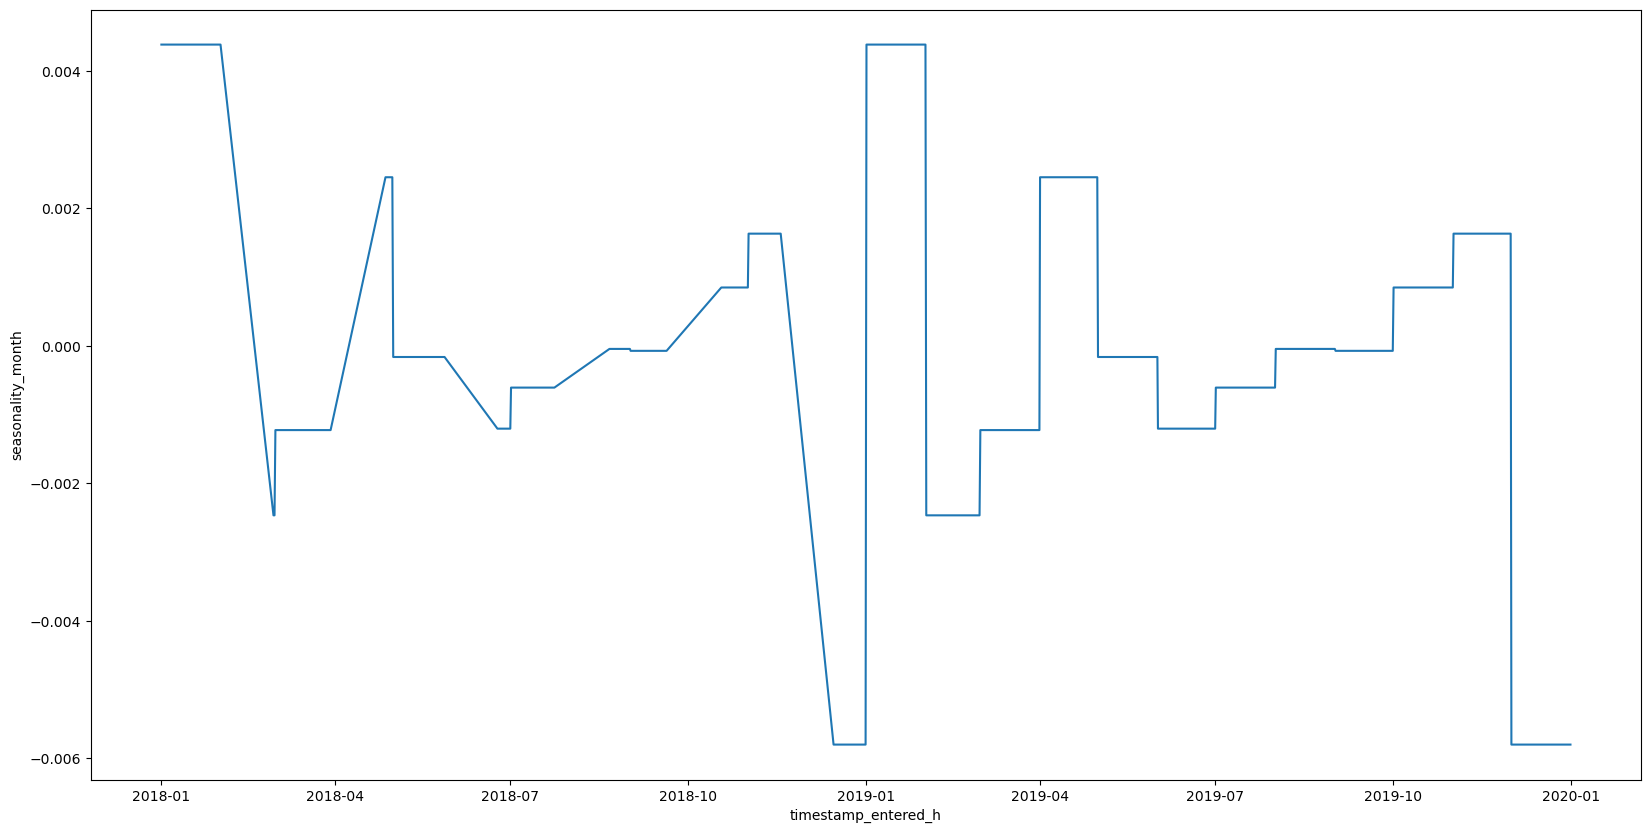

In [16]:
sns.lineplot(data=hourly_df, x='timestamp_entered_h', y='seasonality_month')

plt.gcf().set_size_inches(20, 10)
plt.show()

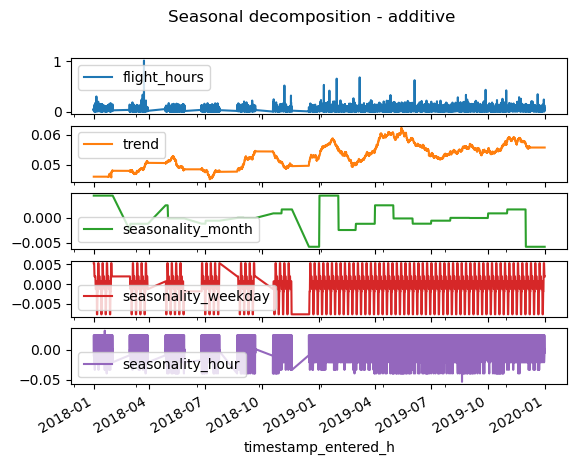

In [22]:
(
    hourly_df
    .loc[:, ["flight_hours", "trend", "seasonality_month", "seasonality_weekday", "seasonality_hour"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

In [18]:
hourly_df

,count,flight_hours,year,month,day_of_year,day_of_month,hour,weekday,day_name,week_of_year,trend,detrended,seasonality,seasonality_month,seasonality_weekday,seasonality_hour
timestamp_entered_h,,,,,,,,,,,,,,,,
2018-01-01 06:00:00+00:00,3,0.048611,2018,1,1,1,6,0,Monday,1,0.045947,0.002664,0.005329,0.004378,0.004378,0.004378
2018-01-01 07:00:00+00:00,3,0.058333,2018,1,1,1,7,0,Monday,1,0.045947,0.012386,0.005329,0.004378,0.004378,0.004378
2018-01-01 08:00:00+00:00,1,0.018056,2018,1,1,1,8,0,Monday,1,0.045947,-0.027892,0.005329,0.004378,0.004378,0.004378
2018-01-01 09:00:00+00:00,3,0.063889,2018,1,1,1,9,0,Monday,1,0.045947,0.017942,0.005329,0.004378,0.004378,0.004378
2018-01-01 10:00:00+00:00,3,0.030556,2018,1,1,1,10,0,Monday,1,0.045947,-0.015392,0.005329,0.004378,0.004378,0.004378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:00:00+00:00,2,0.018056,2019,12,365,31,15,1,Tuesday,1,0.055720,-0.037664,0.001964,-0.005800,-0.005800,-0.005800
2019-12-31 16:00:00+00:00,3,0.065278,2019,12,365,31,16,1,Tuesday,1,0.055720,0.009558,0.001964,-0.005800,-0.005800,-0.005800
2019-12-31 18:00:00+00:00,2,0.037500,2019,12,365,31,18,1,Tuesday,1,0.055720,-0.018220,0.001964,-0.005800,-0.005800,-0.005800
